##Análise de Fraude

Objetivo deste projeto e avaliar dataset com modelo de Regressão Logistica, não vamos compara-lo a outros modelos porque este não é objetivo nossa variável de estudo apresenta a característica categorica binária.O dataset de estudo se encontra no link.'https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud'.

In [2]:
#Importação dos pacotes
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [3]:
#importação do banco de dados

data=pd.read_csv('https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Ao observarmos os dados acima notamos que a variável Amount  não está padronizada, portanto é proximo passo a seguir.

In [4]:
#padronização da variavel Amount
data['normAmount'] = StandardScaler().fit_transform(np.array(data['Amount']).reshape(-1, 1))


In [5]:
#drop das variáveis que não serão utilizadas
data = data.drop(['Time', 'Amount'], axis = 1)

In [6]:
#verificando valores nulos
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   V1          284807 non-null  float64
 1   V2          284807 non-null  float64
 2   V3          284807 non-null  float64
 3   V4          284807 non-null  float64
 4   V5          284807 non-null  float64
 5   V6          284807 non-null  float64
 6   V7          284807 non-null  float64
 7   V8          284807 non-null  float64
 8   V9          284807 non-null  float64
 9   V10         284807 non-null  float64
 10  V11         284807 non-null  float64
 11  V12         284807 non-null  float64
 12  V13         284807 non-null  float64
 13  V14         284807 non-null  float64
 14  V15         284807 non-null  float64
 15  V16         284807 non-null  float64
 16  V17         284807 non-null  float64
 17  V18         284807 non-null  float64
 18  V19         284807 non-null  float64
 19  V2

Como observado acima o dataset não apresenta valores nulos.

In [7]:
#observando class fraude
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

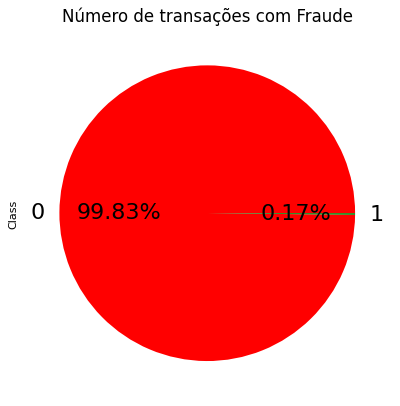

In [ ]:
#data['Class'].value_counts().plot(kind='bar', title='Numero de fraudes = 1');
fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)
ax.set_title('Número de transações com Fraude', fontdict={'size':15})
data['Class'].value_counts().plot.pie(

    labels=["0", "1"],

    colors=["r", "g", "b", "c"],

    autopct='%1.2f%%',

    fontsize=20,

    figsize=(6, 6),

);
plt.show()

É nitido que nossas classes estão desbalanceadas, se apenas aplicamos a modelagem sem tirar esse desbalanceamento teremos problemas quanto a classificação de nosso modelo. Aplicaremos duas técnicas a seguir uma de undersampling e oversampling.

##UNDERSAMPLING NEARMISS

Vamos começar aplicando o método que diminui a quantidade de observações com maior número de classificação, afim de equalizar.

In [9]:
#separando os dados entre X as variáveis preditoras e y a variável resposta.

X=data.drop(['Class'],axis=1)
y=data.iloc[:,28]


#aplicando a técnica de undersampling NearMiss.

nm=NearMiss(version=1)

X_under,y_under=nm.fit_resample(X,y)

#separando conjunto de dados em treino e teste em 80/20.

X_train, X_test, y_train, y_test = train_test_split(X_under,y_under, test_size = 0.2, random_state = 5)

#aplicando ao modelo para obter a acuracia e recall  junto com matriz de confusão

modelo=LogisticRegression(max_iter=1000)

#validação cruzada para classes desbalanceadas RepeatedStratifiedKFold
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=5)

scores = cross_val_score(modelo,X_under,y_under, scoring='accuracy', cv=cv, n_jobs=-1)


#treino modelo
modelo.fit(X_train,y_train)
pred=modelo.predict(X_test)

print(classification_report(y_test, pred))
print('Acuracia com CV: %.3f (%.3f)' % (mean(scores), std(scores)))


              precision    recall  f1-score   support

           0       0.93      0.98      0.95        92
           1       0.98      0.93      0.96       105

    accuracy                           0.95       197
   macro avg       0.95      0.96      0.95       197
weighted avg       0.96      0.95      0.95       197

Acuracia com CV: 0.951 (0.020)


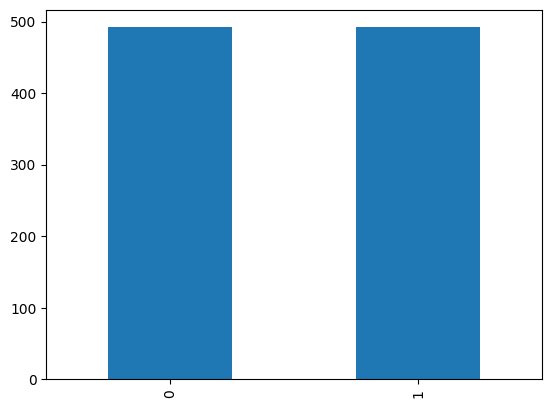

In [10]:



y_under.value_counts().plot(kind='bar');

nosso modelo obteve uma precisão de 98% e um recall 93% com uma acuracia de 95% podemos considerar que ele está tendo uma boa classificação em detectar fraude.

##OVERSAMPLING SMOTE

O método que replica as observações com menor quantidade para se equalizar em números de classificação,afim de se equalizar.

In [11]:
#aplicando a técnica de oversampling SMOTE.

sm=SMOTE()

X_over,y_over=sm.fit_resample(X,y)

#separando conjunto de dados em treino e teste em 80/20.

X_train, X_test, y_train, y_test = train_test_split(X_over,y_over, test_size = 0.2, random_state = 5)

#aplicando ao modelo para obter a acuracia e o recall matriz de confusão

modelo=LogisticRegression(max_iter=1000)

#validação cruzada para classes desbalanceadas RepeatedStratifiedKFold
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=5)

scores = cross_val_score(modelo,X_over,y_over, scoring='accuracy', cv=cv, n_jobs=-1)

#treino do modelo
modelo.fit(X_train,y_train)
pred=modelo.predict(X_test)

print(classification_report(y_test, pred))
print('Acuracia com CV: %.3f (%.3f)' % (mean(scores), std(scores)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     56751
           1       0.97      0.92      0.95     56975

    accuracy                           0.95    113726
   macro avg       0.95      0.95      0.95    113726
weighted avg       0.95      0.95      0.95    113726

Acuracia com CV: 0.946 (0.001)


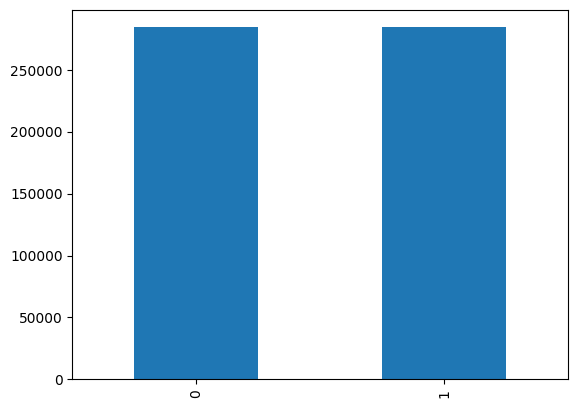

In [12]:
y_over.value_counts().plot(kind='bar');

O modelo obteve uma precisão de 97% recall 92% e a acuracia de 95%, ele tem uma boa classificação em detectar dados de uma fraude.

##Conclusão

O modelo de Regressão logistica obteve alta precisão e ótima acurácia aplicando os métodos de undersampling e oversampling para balancear as classes,nosso objetivo neste projeto foi alcançado. Como dito antes esse não é unico modelo que trabalhe com este tipo de dados, mais a explicação de seus parâmetros é mais facil.